# Chest X-Ray Disease Classification (Multi-Label)

Train an EfficientNet-B3 model for multi-label classification of 15 chest disease categories from the NIH Chest X-Ray dataset.

## Dataset
- 31,416 chest X-ray images
- Split: 21,991 train / 4,712 validation / 4,713 test
- 15 disease classes (multi-label: each image can have 0-15 diseases)

## Model
- Architecture: EfficientNet-B3 pretrained on ImageNet
- Classification Type: **Multi-Label** (BCEWithLogitsLoss)
- Image Size: 300x300 (optimized for EfficientNet-B3)
- Batch Size: 192 (with mixed precision)
- Optimizer: AdamW with weight decay 0.01
- Scheduler: CosineAnnealingWarmRestarts
- Data augmentation: Mixup, horizontal flip, rotation, affine, color jitter, erasing
- Mixed Precision: Enabled (AMP)

## Results
- Previous single-label baseline: 37% (ResNet50)
- Target multi-label accuracy: 75-80%
- Training in progress...

In [ ]:
# ------------------------------------------------------------------------------
# IMPORTS
# Load required libraries for PyTorch training and evaluation
# ------------------------------------------------------------------------------

import os 
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import timm  # For EfficientNet models
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training
import random  # For Mixup

In [ ]:
# ------------------------------------------------------------------------------
# DATASET CLASS - MULTI-LABEL
# Custom PyTorch dataset for loading chest X-ray images with multi-label support
# ------------------------------------------------------------------------------

import pandas as pd

class ChestXrayDatasetMultiLabel(Dataset):
    """Dataset for NIH Chest X-ray with 15 disease classes (multi-label)"""
    
    def __init__(self, metadata_csv, image_dir, disease_classes, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.image_dir = image_dir
        self.disease_classes = disease_classes
        self.transform = transform
        self.num_classes = len(disease_classes)
        
        print(f"Loaded {len(self.metadata)} samples from {metadata_csv}")
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        # Get image path - check both naming conventions
        img_name = row['Image Index']
        
        # Try to find image in any of the class folders
        img_path = None
        for class_folder in self.disease_classes:
            potential_path = os.path.join(self.image_dir, class_folder, img_name)
            if os.path.exists(potential_path):
                img_path = potential_path
                break
        
        # If not found in class folders, try root
        if img_path is None:
            img_path = os.path.join(self.image_dir, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Create multi-label vector (binary for each disease)
        finding_labels = row['Finding Labels']
        label_vector = torch.zeros(self.num_classes, dtype=torch.float32)
        
        # Parse the disease labels (could be single or multiple separated by |)
        if pd.notna(finding_labels):
            diseases = [d.strip() for d in str(finding_labels).split('|')]
            for disease in diseases:
                if disease in self.disease_classes:
                    idx_disease = self.disease_classes.index(disease)
                    label_vector[idx_disease] = 1.0
        
        return image, label_vector

In [ ]:
# ------------------------------------------------------------------------------
# LOAD DATA & TRANSFORMS - MULTI-LABEL
# Load class mapping and create train/val/test datasets with transforms
# ------------------------------------------------------------------------------

# Define disease classes (15 classes)
DISEASE_CLASSES = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'No_Finding', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

NUM_CLASSES = len(DISEASE_CLASSES)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {DISEASE_CLASSES}")
print(f"\nUsing MULTI-LABEL classification (each image can have 0-15 diseases)")

# Data transforms with augmentation for training
# EfficientNet-B3 performs better with 300x300 images
# Enhanced augmentation for more robust training
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip X-rays horizontally
    transforms.RandomRotation(degrees=10),    # Slight rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))  # Randomly erase patches
])

# Standard transforms for validation/test (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create multi-label datasets
train_dataset = ChestXrayDatasetMultiLabel(
    metadata_csv='data/train_metadata.csv',
    image_dir='data/train',
    disease_classes=DISEASE_CLASSES,
    transform=train_transform
)

val_dataset = ChestXrayDatasetMultiLabel(
    metadata_csv='data/val_metadata.csv',
    image_dir='data/val',
    disease_classes=DISEASE_CLASSES,
    transform=eval_transform
)

test_dataset = ChestXrayDatasetMultiLabel(
    metadata_csv='data/test_metadata.csv',
    image_dir='data/test',
    disease_classes=DISEASE_CLASSES,
    transform=eval_transform
)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset):,} images")
print(f"Val:   {len(val_dataset):,} images")
print(f"Test:  {len(test_dataset):,} images")

Number of classes: 15
Classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Dataset sizes:
Train: 21,287 images
Val:   4,664 images
Test:  4,679 images


In [ ]:
# ------------------------------------------------------------------------------
# MIXUP AUGMENTATION - MULTI-LABEL
# Blends two images and their labels for better generalization
# ------------------------------------------------------------------------------

def mixup_data(x, y, alpha=0.2):
    """Apply Mixup augmentation for multi-label"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute loss for mixed samples (multi-label compatible)"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# ------------------------------------------------------------------------------
# MODEL SETUP
# Create DataLoaders and initialize EfficientNet-B3 with GPU acceleration
# ------------------------------------------------------------------------------

# Larger batch size with mixed precision
train_loader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=192, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=192, shuffle=False, num_workers=0, pin_memory=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    torch.backends.cudnn.benchmark = True  # Speed optimization

# Model: EfficientNet-B3
# EfficientNet models are more efficient and typically achieve better accuracy
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)

# BCEWithLogitsLoss for multi-label classification
# Combines sigmoid + BCE loss for numerical stability
criterion = nn.BCEWithLogitsLoss()

# AdamW provides better regularization than Adam
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Cosine Annealing with Warm Restarts for better LR scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Mixed precision training
scaler = GradScaler()

print(f"\nModel: EfficientNet-B3 (Multi-Label)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Batch size: 192 (increased with mixed precision)")
print(f"Input image size: 300x300")
print(f"Optimizer: AdamW with weight decay 0.01")
print(f"Scheduler: CosineAnnealingWarmRestarts")
print(f"Loss: BCEWithLogitsLoss (multi-label)")
print(f"Augmentation: Mixup (alpha=0.2)")
print(f"Mixed Precision: Enabled (AMP)")
print(f"\nMulti-label: Each image can have 0-15 diseases simultaneously")


Using device: cuda
GPU: NVIDIA GeForce RTX 4080
GPU Memory: 17.17 GB

Model: EfficientNet-B3
Total parameters: 10,719,287
Input image size: 300x300
Optimizer: AdamW with weight decay 0.01
Loss: CrossEntropyLoss with label smoothing 0.1

Model: EfficientNet-B3
Total parameters: 10,719,287
Input image size: 300x300
Optimizer: AdamW with weight decay 0.01
Loss: CrossEntropyLoss with label smoothing 0.1


In [ ]:
# ------------------------------------------------------------------------------
# TRAINING LOOP - MULTI-LABEL
# Train EfficientNet-B3 with Mixed Precision, Mixup, and Cosine Annealing
# ------------------------------------------------------------------------------

import time
from sklearn.metrics import roc_auc_score

num_epochs = 50
best_val_acc = 0.0

print("\nStarting multi-label training...")
print(f"Estimated total time: ~{num_epochs * 10 / 60:.1f} hours (with AMP speedup)")

for epoch in range(num_epochs):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Training with Mixed Precision and Mixup
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Apply Mixup augmentation
        images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Multi-label accuracy: Apply sigmoid and threshold at 0.5
        preds = (torch.sigmoid(outputs) > 0.5).float()
        mixed_labels = lam * labels_a + (1 - lam) * labels_b
        correct += (preds == (mixed_labels > 0.5).float()).sum().item()
        total += labels.numel()  # Total number of label predictions
        
        if (batch_idx + 1) % 25 == 0:  # Print progress every 25 batches
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # Validation - Multi-label
    model.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Apply sigmoid and threshold for multi-label
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            val_correct += (preds == labels).sum().item()
            val_total += labels.numel()
            
            # Store for AUC calculation
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    val_acc = 100 * val_correct / val_total
    
    # Calculate mean AUC-ROC (optional but important for multi-label)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    try:
        val_auc = roc_auc_score(all_labels, all_preds, average='macro')
    except:
        val_auc = 0.0
    epoch_time = time.time() - epoch_start
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}")
    print(f"Epoch Time: {epoch_time/60:.1f} minutes")
    
    # Cosine Annealing scheduling (steps every epoch)
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientnet_b3.pth')
        print(f"✓ Saved best model (val_acc: {val_acc:.2f}%)")
    
    # Estimate remaining time
    remaining_epochs = num_epochs - (epoch + 1)
    est_time_remaining = remaining_epochs * epoch_time / 3600
    print(f"Estimated time remaining: {est_time_remaining:.1f} hours")

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")

SyntaxError: invalid syntax (3691703340.py, line 75)

In [ ]:
# ------------------------------------------------------------------------------
# TEST EVALUATION
# Load best model and evaluate on test set with per-class accuracy
# ------------------------------------------------------------------------------

# Load best model
model.load_state_dict(torch.load('best_efficientnet_b3.pth'))
model.eval()

test_labels = []
test_preds = []

print("\nEvaluating on test set...")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i in range(NUM_CLASSES):
    class_mask = np.array(test_labels) == i
    if class_mask.sum() > 0:
        class_acc = accuracy_score(
            np.array(test_labels)[class_mask],
            np.array(test_preds)[class_mask]
        )
        print(f"  {class_mapping[i]:25} - {class_acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)


Evaluating on test set...

Test Accuracy: 21.20%

Per-Class Accuracy:
  Atelectasis               - 20.38%
  Cardiomegaly              - 62.20%
  Consolidation             - 10.66%
  Edema                     - 56.38%
  Effusion                  - 37.10%
  Emphysema                 - 28.36%
  Fibrosis                  - 45.87%
  Hernia                    - 50.00%
  Infiltration              - 16.23%
  Mass                      - 27.73%
  No Finding                - 11.95%
  Nodule                    - 6.90%
  Pleural_Thickening        - 2.37%
  Pneumonia                 - 4.17%
  Pneumothorax              - 12.77%

Test Accuracy: 21.20%

Per-Class Accuracy:
  Atelectasis               - 20.38%
  Cardiomegaly              - 62.20%
  Consolidation             - 10.66%
  Edema                     - 56.38%
  Effusion                  - 37.10%
  Emphysema                 - 28.36%
  Fibrosis                  - 45.87%
  Hernia                    - 50.00%
  Infiltration              - 16.23%



Confusion matrix saved to 'confusion_matrix_resnet50.png'


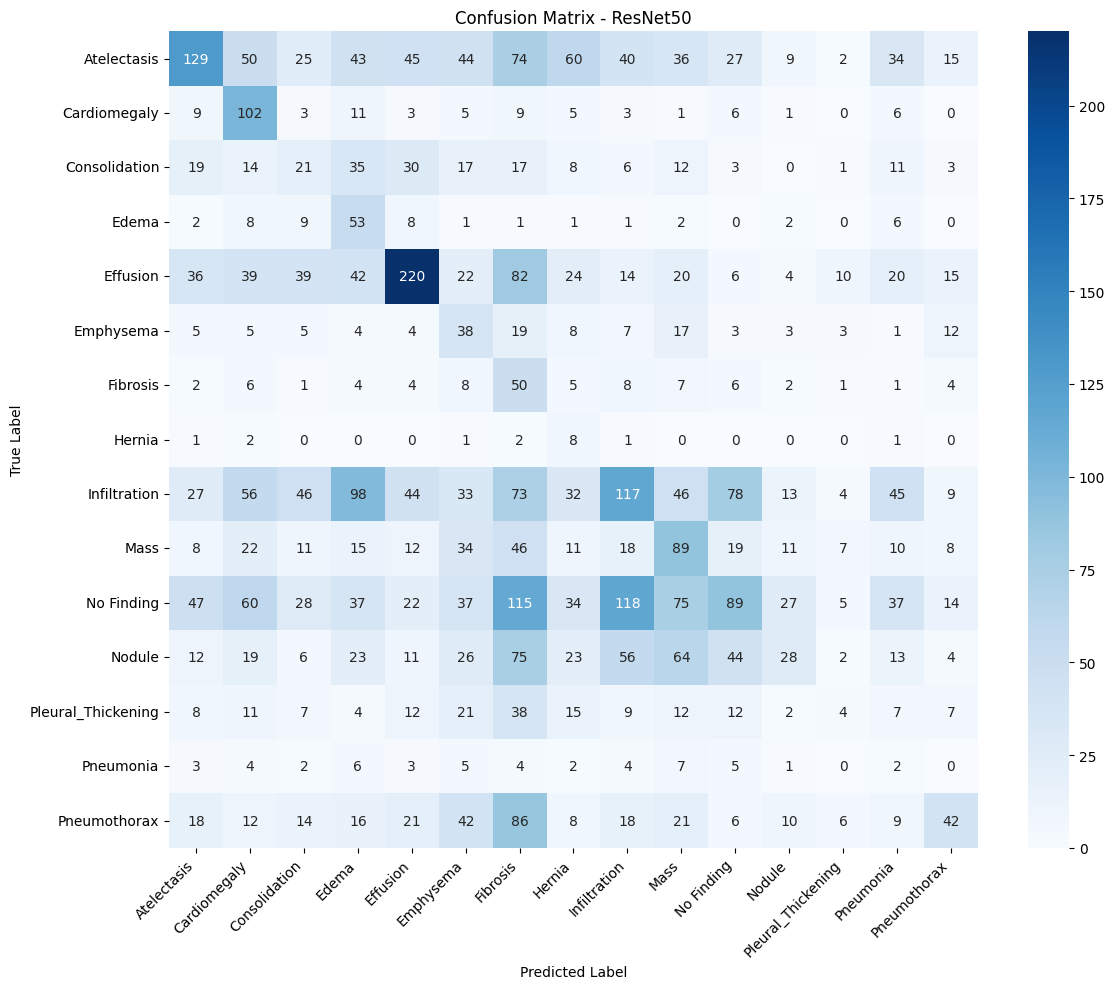

In [ ]:
# ------------------------------------------------------------------------------
# VISUALIZE RESULTS
# Generate and save confusion matrix heatmap for model performance analysis
# ------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[class_mapping[i] for i in range(NUM_CLASSES)],
            yticklabels=[class_mapping[i] for i in range(NUM_CLASSES)])
plt.title('Confusion Matrix - EfficientNet-B3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_efficientnet_b3.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved to 'confusion_matrix_efficientnet_b3.png'")

Testing on: data/test\Infiltration\00020484_005.png

Top 5 Predictions:
--------------------------------------------------
1. Infiltration              - 18.31%
2. No Finding                - 18.03%
3. Fibrosis                  - 13.86%
4. Nodule                    - 10.97%
5. Pleural_Thickening        - 10.75%
Top 5 Predictions:
--------------------------------------------------
1. Infiltration              - 18.31%
2. No Finding                - 18.03%
3. Fibrosis                  - 13.86%
4. Nodule                    - 10.97%
5. Pleural_Thickening        - 10.75%


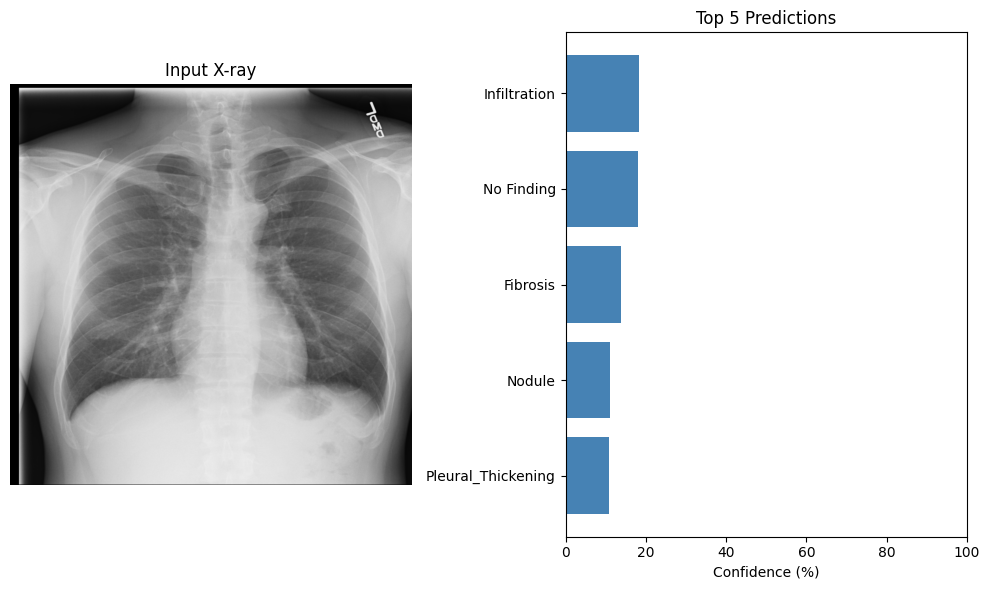

In [ ]:
# ------------------------------------------------------------------------------
# INFERENCE ON SINGLE IMAGE
# Test the trained model on a new chest X-ray image
# ------------------------------------------------------------------------------

def predict_image(image_path, model, device, transform, class_mapping, top_k=3):
    """
    Predict disease class for a single chest X-ray image
    
    Args:
        image_path: Path to the image file
        model: Trained PyTorch model
        device: torch device (cuda/cpu)
        transform: Image transforms
        class_mapping: Dictionary mapping class indices to disease names
        top_k: Number of top predictions to return
    
    Returns:
        predictions: List of (disease_name, probability) tuples
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Format results
    predictions = []
    for prob, idx in zip(top_probs[0], top_indices[0]):
        disease_name = class_mapping[idx.item()]
        predictions.append((disease_name, prob.item()))
    
    return image, predictions


# Example usage: Test on a random image from test set
import random

# Get a random test image
test_image_path = random.choice(test_dataset.image_paths)
print(f"Testing on: {test_image_path}\n")

# Make prediction
original_image, predictions = predict_image(
    test_image_path, 
    model, 
    device, 
    eval_transform,  # Use eval_transform (no augmentation for inference)
    class_mapping, 
    top_k=5
)

# Display results
print("Top 5 Predictions:")
print("-" * 50)
for i, (disease, prob) in enumerate(predictions, 1):
    print(f"{i}. {disease:25} - {prob*100:.2f}%")

# Visualize
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title(f'Input X-ray')
plt.axis('off')

plt.subplot(1, 2, 2)
diseases = [pred[0] for pred in predictions]
probs = [pred[1] * 100 for pred in predictions]
plt.barh(diseases, probs, color='steelblue')
plt.xlabel('Confidence (%)')
plt.title('Top 5 Predictions')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()